# Optimal Latent Space for EEG data
This notebook uses the DEAP dataset. It is my attempt to replicate the preprocessing steps described in the IEEE research article "Examining the Size of the Latent Space of Convolutional Variational Autoencoders Trained with Spectral Topographic Maps of EEG Frequency Bands".


After preprocessing is complete, I plan to feed the data into the Conv-VAE to determine if the results from the referenced paper can be replicated.

## Imports

Run this section first


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/E299/data_preprocessed_python.zip > /dev/null

replace data_preprocessed_python/s01.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
pip install tqdm

In [ ]:
pip install mne


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.fft as fft
from scipy.fft import fft, fftfreq
from scipy import signal
import mne
import pickle
from PIL import Image


from tqdm import tqdm
import time

In [ ]:
# # Removing directories
# !rm -rf book_data
# !rm -rf __MACOSX


## Exploratory Data Analysis of raw eeg data

This section contains code that analyzed raw data and testing functions to be used in the main processing pipeline. Code here does not need to be runned to apply processing pipleline.

In [ ]:
x = pickle.load(open('data_preprocessed_python/s01.dat', 'rb'), encoding= 'latin1')

# data  : 40x40x8064, video/trial x channel x data
# labels: 40x4 , video/trial x label

In [ ]:
# Trial
print("Number of trials:", len(x['data']))

# Channel
print("Number of channels:",len(x['data'][0]))

# Data
print("Number of datapoints:",len(x['data'][0][0]))

Number of trials: 40
Number of channels: 40
Number of datapoints: 8064


In [ ]:
# Labels represent a score on a scale of 1-9 (Arousal, Valence, Dominance, Liking)
# x['labels']

#### Examining raw data

<function matplotlib.pyplot.show(close=None, block=None)>

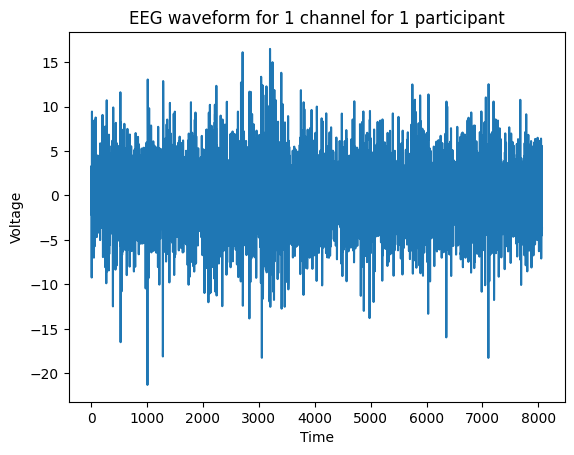

In [ ]:
# Each recording/trial is 1 minute long

time = np.arange(1,8065)

plt.xlabel("Time")
plt.ylabel("Voltage")
plt.plot(time,x['data'][0][0])
plt.title("EEG waveform for 1 channel for 1 participant")
plt.show

In [ ]:
# The dataset has 40 channels, but for our purposes we only care about the first 32
range(len(x['data'][31])-8)


range(0, 32)

<function matplotlib.pyplot.show(close=None, block=None)>

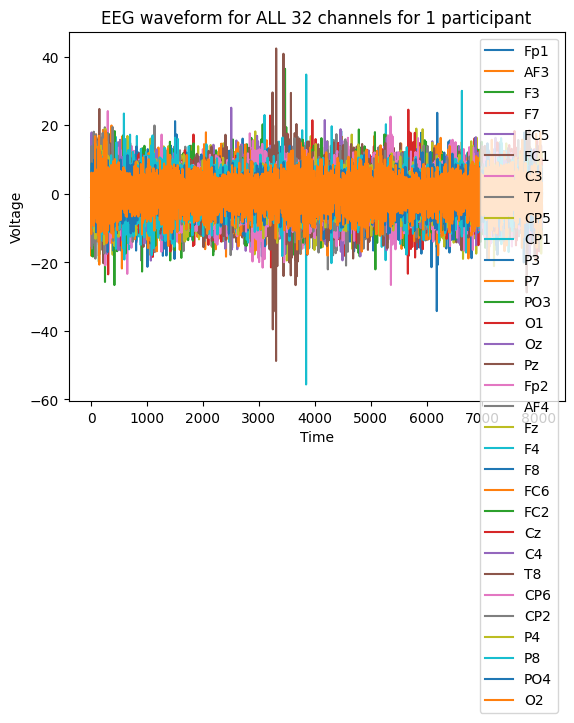

In [ ]:
# Testing - plotting all EEG waveforms
time = np.arange(1,8065)


# Ordering of the electrodes are as described here:
# https://www.eecs.qmul.ac.uk/mmv/datasets/deap/readme.html

electrode_names = [ 'Fp1', 'AF3', 'F3','F7','FC5','FC1','C3','T7','CP5','CP1',
                    'P3', 'P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4',
                    'F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8',
                    'PO4','O2']

plt.xlabel("Time")
plt.ylabel("Voltage")
plt.title("EEG waveform for ALL 32 channels for 1 participant")

for i in range(len(x['data'][31])-8):
  plt.plot(time,x['data'][i][0], label=electrode_names[i])

plt.legend()
plt.show

In [ ]:
# Showing the whole waveform for 1 channel for 1 participant

sampling_rate = 8064 / 60000  # Data points per millisecond
duration = 60000  # Duration in seconds

time = np.arange(0, duration, 1 / sampling_rate)


plt.xlabel("Time (s)")
plt.ylabel("Voltage (uV)")
plt.plot(time, x['data'][0][0])
plt.title("EEG waveform for 1 channel for 1 participant")
plt.grid()
plt.show

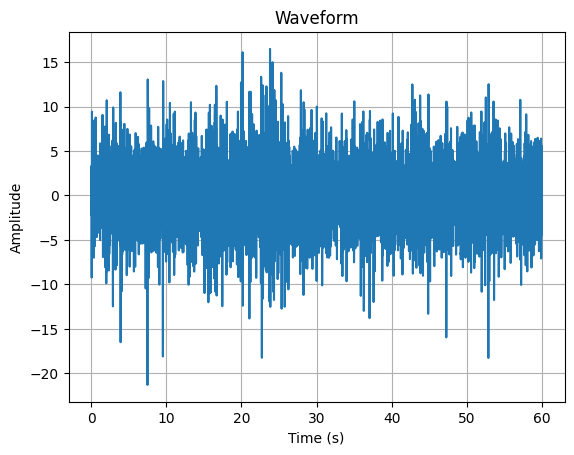

In [ ]:
waveform = x['data'][0][0]

sampling_rate = 8065 / 60  # 8065 datapoints collected over 1 minute

# Calculate the time values for the x-axis
time = np.arange(len(waveform)) / sampling_rate

# Plot the waveform
plt.plot(time, waveform)

# Set the x-axis label, y-axis label, and title
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')

# Display the plot
plt.grid()
plt.show()

In [ ]:
len(time)

In [ ]:
waveform = x['data'][0][0]

sampling_rate = 8065 / 60  # 8065 datapoints collected over 1 minute

# Calculate the time values for the x-axis
time = np.arange(len(waveform)) / sampling_rate

# Plot the waveform
plt.plot(time, waveform)

# Set the x-axis label, y-axis label, and title
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')

# Display the plot
plt.grid()
plt.show()

##### Sliding window function

In [ ]:
# Main function
def sliding_window(data, window_size, shift):
    """
    Function takes in EEG data in the form of a numpy array.
    Returns the segmented data.

    Input:
        data: raw eeg data, numpy array
        window_size: size of window, int
        shift: shift size of window, int

    Output:
        time_slices: list of time-slices of size window_size with a shift of shift_size.
        Each element in the list is a time-slice of size window_size with a shift of shift_size.

    """



    window_samples = int(window_size * 1000)  # Convert window size from seconds to milliseconds
    shift_samples = int(shift * 1000)  # Convert shift size from seconds to milliseconds

    num_windows = int((len(data) - window_samples) / shift_samples) + 1

    windows = []
    for i in range(num_windows):
        start = i * shift_samples
        end = start + window_samples
        window = data[start:end]
        windows.append(window)

    return windows

# Assuming your EEG waveform data is stored in a NumPy array called 'eeg_data'
window_size = 2.0  # Window size in seconds
shift = 0.125  # Shift size in seconds

# Taken from raw data
eeg_data = x['data'][0][0]

# Applying function
time_slices = sliding_window(eeg_data, window_size, shift)

# Each element in 'time_slices' is a time-slice of size 0.5 seconds with a 125ms shift
print(f"Number of slices:", len(time_slices))  # a list of np arrays
print(f"Length of each slice:",len(time_slices[0]))
print(f"Data type of a single slice:",type(time_slices[0]))


Number of slices: 49
Length of each slice: 2000
Data type of a single slice: <class 'numpy.ndarray'>


#### Plotting the sliced eeg waveform

In [ ]:
# Plotting EEG Waveform

# Calculate the time points for each time-slice
time_points = np.arange(0, len(time_slices[0])) * shift + window_size / 2
time_points

# # Plot each time-slice
# for i, time_slice in enumerate(time_slices):
#     plt.plot(time_slice + i, label=f"Time-slice {i + 1}")

# Plot a single time-slice
plt.plot(time_slices[0], label=f"Time-slice")


plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Time-slice of 1 waveform for 1 participant ')
#plt.legend()
plt.grid()
plt.show()

#### Applying PSD

In [ ]:
# Computing power spectral density - via Welch periodogram
# Reference:
# https://raphaelvallat.com/bandpower.html

# Computing an estimate of the power spectral density - via Welch's peridogram
# Welch - Averages consecutive FFT of small windows of the signal
# This method improves accuracy of periodogram (estimate of a spectral density of a signal)

# Periodogram requires spectral content of the signal to be stationary (time-unvarying)
# This is not the case for EEG signals, hence produced periodogram can be BIASED and have a high variance
# Averaging periodograms over short segments of windows - Welch method can reduce this variance
# This comes at the COST of lower frequency resolution


# Trial
print("Number of trials:", len(x['data']))

# Channel
print("Number of channels:",len(x['data'][0]))

# Data
print("Number of datapoints:",len(x['data'][0][0]))
print("Data type:",type(x['data'][0][0]))


# Each element in 'time_slices' is a time-slice of size 0.5 seconds with a 125ms shift
print(f"Number of slices:", len(time_slices))  # a list of np arrays
print(f"Length of each slice:",len(time_slices[0]))
# print(f"Data type of a single slice:",type(time_slices[0]))


In [ ]:
len(x['data'][0][1])

8064

In [ ]:
# Turning PSD code into a function
from scipy import signal

def find_psd(time_slices, sampling_freq=128):

  segmented_data = time_slices


  win = 4 * sampling_freq


  freqs, psd = signal.welch(segmented_data, sampling_freq, nperseg=win)

  return freqs, psd

freqs, psd = find_psd(time_slices[0])

# Plot the power spectrum
# sns.set(font_scale=1.2, style='white')
# plt.figure(figsize=(8, 4))
# plt.plot(freqs, psd, color='k', lw=2)
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power spectral density (V^2 / Hz)')
# plt.ylim([0, psd.max() * 1.1])
# plt.title("Welch's periodogram")
# plt.xlim([0, freqs.max()])
# sns.despine()

### Creating TOPO maps

Topographic EEG headmaps from each time slice for each participant and each video is created

- Centroid of the frequency amplitude for EACH band is computed , for a time slice

- Centroids positioned in 3D space to produce scattered head map, ONE for each band

- Polar projection is applied to each scattered map to produce 2D head maps

- EACH 2D map is interpolated into 5 2D maps

In [ ]:
print(f"Number of slices:", len(time_slices))
print(f"Data type of a single slice:",type(time_slices))

In [ ]:
# Matching the frequencies with the corresponding psd value produced from signal.welch
# Used to determined the dominant frequency of a signal

# For the Delta waveband
print('Delta frequencies: ',freqs[2:17]) # these index correspond to the freq range of the delta band (0.5-4 Hz)
print('Delta psd: ', psd[2:17])

In [ ]:
# Delta: 0.5-4 Hz, Theta: 4-8 Hz, Alpha: 8-12Hz, Beta: 12-30Hz, Gamma: 30-45Hz

# Spectral Centroid DELTA bands
delta_freq = freqs[2:16]
delta_psd = psd[2:16]
delta_centroid = np.sum(delta_freq*delta_psd)/ np.sum(delta_psd)
print("Delta band centroid:",delta_centroid)

# Spectral Centroid THETA bands
theta_freq = freqs[16:32]
theta_psd = psd[16:32]
theta_centroid = np.sum(theta_freq*theta_psd)/ np.sum(theta_psd)
print("Theta band centroid:",theta_centroid)

# Spectral Centroid ALPHA bands
alpha_freq = freqs[32:47]
alpha_psd = psd[32:47]
alpha_centroid = np.sum(alpha_freq*alpha_psd)/ np.sum(alpha_psd)
print("Alpha band centroid:",alpha_centroid)

# Spectral Centroid BETA bands
beta_freq = freqs[47:118]
beta_psd = psd[47:118]
beta_centroid = np.sum(beta_freq*beta_psd)/ np.sum(beta_psd)
print("Beta band centroid:",beta_centroid)

# Spectral Centroid GAMMA bands
gamma_freq = freqs[118:176]
gamma_psd = psd[118:176]
gamma_centroid = np.sum(gamma_freq*gamma_psd)/ np.sum(gamma_psd)
print("Gamma band centroid:",gamma_centroid)


# Processing pipeline

Processing pipe line to load and preprocess raw EEG signals

#### Functions

In [ ]:
# Initiating all relevant functions

window_size = 0.5  # Window size in seconds
shift = 0.125  # Shift size in seconds


def sliding_window(data, window_size, shift):
    """
    Function takes in EEG data in the form of a numpy array.
    Returns the segmented data.

    Input:
        data: raw eeg data, numpy array
        window_size: size of window, int
        shift: shift size of window, int

    Output:
        time_slices: list of time-slices of size 'window_size' with a shift of 'shift_size'.
        Each element in the list is a time-slice of size 'window_size' with a shift of 'shift_size'.

    """

    window_samples = int(window_size * 1000)  # Convert window size from seconds to milliseconds
    shift_samples = int(shift * 1000)  # Convert shift size from seconds to milliseconds

    num_windows = int((len(data) - window_samples) / shift_samples) + 1

    windows = []
    for i in range(num_windows):
        start = i * shift_samples
        end = start + window_samples
        window = data[start:end]
        windows.append(window)

    return windows


def find_psd(time_slices, sampling_freq=128):

  segmented_data = time_slices # EDIT ME -- FIXED

  # Define window length (4 seconds)
  win = 4 * sampling_freq

  # This returns freqs: array of frequencies , psd: Power spectral density or power spectrum of x
  freqs, psd = signal.welch(segmented_data, sampling_freq, nperseg=win)

  return freqs, psd

def waveband_centroid(eeg_data, waveband, window_size=0.5, shift=0.125, slice_idx=0):

  """
  Function takes in EEG data in the form of a numpy array.
  It performs the following:
  1. Creates time slices via sliding window technique
  2. Find FFT and PSD
  3. Find the centroid of the delta waveband

  Input:
      eeg_data: raw eeg data, numpy array
      waveband: specify type of waveband you want to obtain, str, i.e delta, theta, alpha, beta, gamma
      window_size: size of window, int
      shift: shift size of window, int
      slice_idx: which index of the time slice to process, int

  Output:
    Waveband centroid frequency amplitude, int

  """

  # Applying time slice
  time_slices = sliding_window(eeg_data, window_size, shift)

  # Selecting a single slice - EDIT - THERE ARE 61 SLICES IN TOTAL
  # SOMETHING LIKE THIS:
  time_slice = time_slices[slice_idx]
  #time_slice = time_slices[0]

  # Applying PSD
  freqs, psd = find_psd(time_slice)

  # Modify me to include option to change waveband
  # Adding delta centroid to the list
  if waveband == "delta":
    delta_freq = freqs[2:16]
    delta_psd = psd[2:16]
    centroid = np.sum(delta_freq*delta_psd)/ np.sum(delta_psd)

  elif waveband == "theta":
    theta_freq = freqs[16:32]
    theta_psd = psd[16:32]
    centroid = np.sum(theta_freq*theta_psd)/ np.sum(theta_psd)

  elif waveband == "alpha":
    alpha_freq = freqs[32:47]
    alpha_psd = psd[32:47]
    centroid = np.sum(alpha_freq*alpha_psd)/ np.sum(alpha_psd)

  elif waveband == "beta":
    beta_freq = freqs[47:118]
    beta_psd = psd[47:118]
    centroid = np.sum(beta_freq*beta_psd)/ np.sum(beta_psd)


  elif waveband == "gamma":
    gamma_freq = freqs[118:176]
    gamma_psd = psd[118:176]
    centroid = np.sum(gamma_freq*gamma_psd)/ np.sum(gamma_psd)

  else:
    print("Enter waveband, delta, theta, alpha, beta, gamma")
    return

  return centroid


def plot_topo(centroid_ls, waveband, plot=True):

  """
  Function takes in preoprocessed EEG data and plots the topographic head map.
  Ensure data is normalized before passing into this function

  Input:
    centroid_ls: EEG data that has been preprocessed using waveband_centroid() function,ls
    waveband: Name of waveband that is being plotted, str
    plot: plots fulll headmap with colorbar if set to True ,bool

  Output:
    image data produced from mne.viz.plot_topomap()

  """



  electrode_names = [ 'Fp1', 'AF3', 'F3','F7','FC5','FC1','C3','T7','CP5','CP1',
                      'P3', 'P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4',
                      'F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8',
                      'PO4','O2']

  # Create an info object to hold the electrode positions
  info = mne.create_info(electrode_names, sfreq=1.0, ch_types='eeg')
  montage = mne.channels.make_standard_montage('standard_1020')
  info.set_montage(montage)


  # IF PLOTTING FOR VISUAL PURPOSES
  if plot == True:

    # Plot the topographic map
    fig, ax = plt.subplots()
    im, cm =  mne.viz.plot_topomap(centroid_ls, info, axes=ax,
                        names=electrode_names,
                        cmap="viridis",
                        show=False,
                        sphere=0.105,
                        vlim = (0,1), # remove this line to remove normalized scale in output diagram
                                   )

    # Customize the plot (optional)
    ax.set_title(f'{waveband} Centroid Frequency Amplitudes')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    # Plotting colorbar
    ax_x_start = 0.95
    ax_x_width = 0.04
    ax_y_start = 0.1
    ax_y_height = 0.5
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    text  = "\u00B5V"

    clb.ax.set_title(text,fontsize=10)
    plt.show()

  # Not plotting the full image
  else:
    im, cm =  mne.viz.plot_topomap(centroid_ls, info, axes=None,
                                  names=None,
                                  cmap="viridis",
                                  show=False,
                                  sphere=0.105,
                                  vlim = (0,1), # remove this line to remove normalized scale in output diagram
    )

  return im

def resize_topo(topo):

  data = np.array(topo.get_array())
  # Use PIL to resize the image to 32x32
  image_pil = Image.fromarray(data).resize((32, 32))
  resized_array = np.array(image_pil)

  # convert all nan values to 0
  resized_array[np.isnan(resized_array)] = 0

  return resized_array


#### Processing pipeline

The preprocessing pipeline below can be divided into 3 main sections with substeps for each section. The preprocessing was done as described in the paper "Examining the Size of the Latent Space of Convolutional Variational Autoencoder Trained with Spectral Topographic Maps of EEG Frequency Bands". <br>


Code below is divided as follows:

1. Loading Data <br>
  Unzips data from .dat file

2. EEG signal preprocessing <br>
   For each participant, the following preprocessing steps are done to the EEG signals: <br>
  
  - EEG data is split into discrete time-slices
  - FFT and PSD is applied to each time slice. Power spectrum is divided into 5 EEG bands (delta, theta, alpha, beta, gamma)
  - Centroid frequency amplitude is calculated for each EEG band and then normalized.

3. Creating topgraphic head map <br>
  - Topo data for each waveband is created by plotting the centroid data onto a 2D head map.
  - Data from head map is converted into a numpy array.
  - Each topographic headmap for each waveband is combined to create a 5 channel tensor of size 32x32x5
  - Data is then saved. File path to save the resulting data will need to be specified

NOTE: For a window size of 0.5s, it will create 61 time slices. At this window size, we expect 61 image tensors for each participant. This number may change depending on the window size

In [ ]:
# # Removing directories
# !rm -rf __MACOSX

In [ ]:
for entry in tqdm(range(1)):
  entry = entry+14


entry

100%|██████████| 1/1 [00:00<00:00, 8355.19it/s]

14


14

In [ ]:
## MAIN PIPELINE

dat_file = 'data_preprocessed_python/s01.dat'
entry_num = 32


# 1. LOADING DATA

# Loading in data from zip file
x = pickle.load(open(dat_file, 'rb'), encoding= 'latin1')


# 2. EEG SIGNAL PREPROCESSING

# Setting window size length
file_names = ['05','1','15','2']
window_sizes = [0.5,1.0,1.5,2.0]
base_path = '/content/'

# Iterating over each entry per participant
for entry in tqdm(range(4)):
  entry = entry+entry_num
  entry_path = f"{base_path}entry_{entry}/"


  for id in range(len(window_sizes)):


    file_name = file_names[id] #  to be used when saving folder

    win_size = window_sizes[id] # win_size = 0.5, 61 time slices
    time_slices_range = len(sliding_window(x['data'][0][0], win_size, shift))
    print(f"Number of slices:", time_slices_range)  # a list of np arrays

    # # Iterating over each entry per participant
    # for entry in tqdm(range(15)):
    #   entry_path = f"{base_path}entry_{entry}/"




    # Iterating over the 61 produced time-slices.
    # NOTE: This number may change dependeing on the window size used - see code block above
    for idx in range(time_slices_range):

        # FINDING CENTROID FREQ AMPLITUDE FOR EACH WAVEBAND
        delta_ls = []
        theta_ls = []
        alpha_ls = []
        beta_ls = []
        gamma_ls = []


        # Iterating over all 32 channels used.
        # The applied function will find the psd value for each of the 32 channels and store them all into a list that correspond to their waveband
        for i in range(32):
          eeg_data = x['data'][entry][i]
          delta_ls.append(waveband_centroid(eeg_data,waveband='delta',window_size=win_size, shift=0.125,slice_idx=idx))

        for i in range(32):
          eeg_data = x['data'][entry][i]
          theta_ls.append(waveband_centroid(eeg_data,waveband='theta',window_size=win_size, shift=0.125, slice_idx=idx))

        for i in range(32):
          eeg_data = x['data'][entry][i]
          alpha_ls.append(waveband_centroid(eeg_data,waveband='alpha',window_size=win_size, shift=0.125, slice_idx=idx))

        for i in range(32):
          eeg_data = x['data'][entry][i]
          beta_ls.append(waveband_centroid(eeg_data,waveband='beta',window_size=win_size, shift=0.125, slice_idx=idx))

        for i in range(32):
          eeg_data = x['data'][entry][i]
          gamma_ls.append(waveband_centroid(eeg_data,waveband='gamma',window_size=win_size, shift=0.125, slice_idx=idx))


##############################################################################################################################
        # NORMALIZING DATA IN EACH WAVEBAND

        # Create a list of all five lists
        all_lists = [delta_ls, theta_ls, alpha_ls, beta_ls, gamma_ls]

        # Find the overall minimum and maximum values across all lists
        overall_min = min(min(lst) for lst in all_lists)
        overall_max = max(max(lst) for lst in all_lists)

        # Normalize the values in each list and update the original lists
        for lst in all_lists:
            for i in range(len(lst)):
                lst[i] = (lst[i] - overall_min) / (overall_max - overall_min)


#################################################################################################################################

      # 3. CREATING TOPOGRAPHIC HEAD MAP


        # CREATING TOPO
        delta = plot_topo(delta_ls, 'Delta',plot=False)
        theta = plot_topo(theta_ls, 'Delta',plot=False)
        alpha = plot_topo(alpha_ls, 'Delta',plot=False)
        beta = plot_topo(beta_ls, 'Delta',plot=False)
        gamma = plot_topo(gamma_ls, 'Delta',plot=False)

        # RESIZING THE IMAGE
        resized_delta = resize_topo(delta)
        resized_theta = resize_topo(theta)
        resized_alpha = resize_topo(alpha)
        resized_beta = resize_topo(beta)
        resized_gamma = resize_topo(gamma)

        # CHECKING OUTPUT OF RESIZE FUNCTION
        # print(resized_array)
        # plt.imshow(resized_array, cmap='viridis')
        # plt.show()


        # CREATING THE 32,32,5 TENSOR
        # Create a list of the 5 arrays
        arrays_list = [resized_delta, resized_theta, resized_alpha, resized_beta, resized_gamma]

        # Stack the arrays along a new axis (axis=2) to create the final array
        combined_array = np.stack(arrays_list, axis=0)



        # Saving the data - ENSURE FOLDER IS CREATED AND FOLDER PATH IS SPECIFIED
        file_path = f'/content/entry{entry}/topo{file_name}/' # EDIT FILE PATH TO SAVE TO DESIRED LOCATION

        topo_path = f"{entry_path}topo{file_name}/"
        os.makedirs(topo_path, exist_ok=True)

        iter = idx

        np.save(f"{topo_path}tensor_{iter}.npy", combined_array)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
## Loading the tensor
path = "content/"
#loaded_combined_array = np.load(f"{file_path}tensor_{iter}.npy")


# loaded_combined_array[0][:][:].shape

# Plotting loaded tensor
# plt.imshow(loaded_combined_array[0][:][:])  # 'gray' colormap for grayscale images
# plt.title(f"Channel Image")
# plt.colorbar()  # Optional: add a colorbar to show the intensity scale
# plt.show()

# type(loaded_combined_array)
# for i in tqdm(range(61)):
#   # print(i)

# Zipping and downloading when running on google colab
from google.colab import files

!zip -r /content/entry_32.zip /content/entry_32
files.download("/content/entry_32.zip")

!zip -r /content/entry_33.zip /content/entry_33
files.download("/content/entry_33.zip")

!zip -r /content/entry_34.zip /content/entry_34
files.download("/content/entry_34.zip")

!zip -r /content/entry_35.zip /content/entry_35
files.download("/content/entry_35.zip")

# !zip -r /content/entry_23.zip /content/entry_23
# files.download("/content/entry_23.zip")


  adding: content/entry_32/ (stored 0%)
  adding: content/entry_32/topo05/ (stored 0%)
  adding: content/entry_32/topo05/tensor_55.npy (deflated 13%)
  adding: content/entry_32/topo05/tensor_1.npy (deflated 12%)
  adding: content/entry_32/topo05/tensor_33.npy (deflated 12%)
  adding: content/entry_32/topo05/tensor_36.npy (deflated 13%)
  adding: content/entry_32/topo05/tensor_28.npy (deflated 12%)
  adding: content/entry_32/topo05/tensor_41.npy (deflated 13%)
  adding: content/entry_32/topo05/tensor_2.npy (deflated 12%)
  adding: content/entry_32/topo05/tensor_32.npy (deflated 12%)
  adding: content/entry_32/topo05/tensor_42.npy (deflated 13%)
  adding: content/entry_32/topo05/tensor_44.npy (deflated 13%)
  adding: content/entry_32/topo05/tensor_57.npy (deflated 12%)
  adding: content/entry_32/topo05/tensor_56.npy (deflated 12%)
  adding: content/entry_32/topo05/tensor_43.npy (deflated 13%)
  adding: content/entry_32/topo05/tensor_31.npy (deflated 12%)
  adding: content/entry_32/topo05

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/entry_33/ (stored 0%)
  adding: content/entry_33/topo05/ (stored 0%)
  adding: content/entry_33/topo05/tensor_55.npy (deflated 13%)
  adding: content/entry_33/topo05/tensor_1.npy (deflated 14%)
  adding: content/entry_33/topo05/tensor_33.npy (deflated 12%)
  adding: content/entry_33/topo05/tensor_36.npy (deflated 13%)
  adding: content/entry_33/topo05/tensor_28.npy (deflated 12%)
  adding: content/entry_33/topo05/tensor_41.npy (deflated 12%)
  adding: content/entry_33/topo05/tensor_2.npy (deflated 13%)
  adding: content/entry_33/topo05/tensor_32.npy (deflated 12%)
  adding: content/entry_33/topo05/tensor_42.npy (deflated 13%)
  adding: content/entry_33/topo05/tensor_44.npy (deflated 12%)
  adding: content/entry_33/topo05/tensor_57.npy (deflated 12%)
  adding: content/entry_33/topo05/tensor_56.npy (deflated 12%)
  adding: content/entry_33/topo05/tensor_43.npy (deflated 13%)
  adding: content/entry_33/topo05/tensor_31.npy (deflated 12%)
  adding: content/entry_33/topo05

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/entry_34/ (stored 0%)
  adding: content/entry_34/topo05/ (stored 0%)
  adding: content/entry_34/topo05/tensor_55.npy (deflated 13%)
  adding: content/entry_34/topo05/tensor_1.npy (deflated 13%)
  adding: content/entry_34/topo05/tensor_33.npy (deflated 13%)
  adding: content/entry_34/topo05/tensor_36.npy (deflated 13%)
  adding: content/entry_34/topo05/tensor_28.npy (deflated 13%)
  adding: content/entry_34/topo05/tensor_41.npy (deflated 12%)
  adding: content/entry_34/topo05/tensor_2.npy (deflated 12%)
  adding: content/entry_34/topo05/tensor_32.npy (deflated 12%)
  adding: content/entry_34/topo05/tensor_42.npy (deflated 12%)
  adding: content/entry_34/topo05/tensor_44.npy (deflated 13%)
  adding: content/entry_34/topo05/tensor_57.npy (deflated 13%)
  adding: content/entry_34/topo05/tensor_56.npy (deflated 12%)
  adding: content/entry_34/topo05/tensor_43.npy (deflated 13%)
  adding: content/entry_34/topo05/tensor_31.npy (deflated 13%)
  adding: content/entry_34/topo05

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/entry_35/ (stored 0%)
  adding: content/entry_35/topo05/ (stored 0%)
  adding: content/entry_35/topo05/tensor_55.npy (deflated 13%)
  adding: content/entry_35/topo05/tensor_1.npy (deflated 13%)
  adding: content/entry_35/topo05/tensor_33.npy (deflated 13%)
  adding: content/entry_35/topo05/tensor_36.npy (deflated 12%)
  adding: content/entry_35/topo05/tensor_28.npy (deflated 13%)
  adding: content/entry_35/topo05/tensor_41.npy (deflated 13%)
  adding: content/entry_35/topo05/tensor_2.npy (deflated 12%)
  adding: content/entry_35/topo05/tensor_32.npy (deflated 13%)
  adding: content/entry_35/topo05/tensor_42.npy (deflated 13%)
  adding: content/entry_35/topo05/tensor_44.npy (deflated 12%)
  adding: content/entry_35/topo05/tensor_57.npy (deflated 13%)
  adding: content/entry_35/topo05/tensor_56.npy (deflated 12%)
  adding: content/entry_35/topo05/tensor_43.npy (deflated 13%)
  adding: content/entry_35/topo05/tensor_31.npy (deflated 13%)
  adding: content/entry_35/topo05

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>